# Actor Critic (Pytorch)

In [1]:
from collections import namedtuple, deque
from itertools import count
import random
import copy

import gym
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

eps = np.finfo(np.float32).eps.item()

In [2]:
# ハイパラ
N_EPISODES = 1000
learning_rate = 0.01
N_HIDDEN = 128
gamma = 0.99

env = gym.make('CartPole-v0')
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
reward_threshold = env.spec.reward_threshold

np.random.seed(123)
env.seed(123)
torch.manual_seed(123)

In [3]:
class Actor(nn.Module):
    def __init__(self, in_dim, out_dim, h_dim=64):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(in_dim, h_dim)
        self.l2 = nn.Linear(h_dim, out_dim)
    
    def forward(self, x):
        h = F.relu(self.l1(x))
        h = self.l2(h)
        dist = Categorical(F.softmax(h, dim=-1))
        return dist

class Critic(nn.Module):
    def __init__(self, in_dim, h_dim=64):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(in_dim, h_dim)
        self.l2 = nn.Linear(h_dim, 1)
    
    def forward(self, x):
        h = F.relu(self.l1(x))
        v = F.relu(self.l2(h))
        return v


In [4]:
actor = Actor(obs_size, n_actions)
critic = Critic(obs_size)

opt_act = optim.Adam(actor.parameters())
opt_crit = optim.Adam(critic.parameters())

In [5]:
def compute_returns(rewards, gamma=0.99):
    R = 0
    rets = deque()
    for r in reversed(rewards):
        R = r + gamma * R
        rets.appendleft(R)
    return rets

def update_policy(actor, critic, rewards, log_probs, values):
    returns = compute_returns(rewards)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    actor_loss = []
    critic_loss = []
    for r, l_p, v in zip(returns, log_probs, values):
        advantage = r - v.item()
        actor_loss.append(-l_p * advantage.detach()) # 今回はActorとCriticを分けてるからdetach()はいらないかも
        critic_loss.append(F.smooth_l1_loss(v, torch.tensor(r))) # 見積もりvと実績r + gamma*Rの誤差

    # lossをまとめ上げる
    actor_loss = sum(actor_loss) #torch.cat(policy_loss).sum()
    critic_loss = sum(critic_loss)

    opt_act.zero_grad()
    opt_crit.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    opt_act.step()
    opt_crit.step()


def select_action(policy, state_tensor):
    # 状態を受け取って行動とそのlog_probを返す。
    # state = torch.from_numpy(state).float().unsqueeze(0)
    dist = policy(state)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    
    return action.item(), dist.log_prob(action)

In [6]:
render = False

reward_history = []
for ep in range(N_EPISODES):
    state = env.reset()
    
    done = False

    log_probs = [] # log_probの保存
    values = []    # 価値の保存
    rewards = []   # 報酬の保存
    while not done:
        state = torch.from_numpy(state).float()
        action, log_prob = select_action(actor, state)
        value = critic(state)

        n_state, reward, done, _ = env.step(action)

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)

        # 状態の更新
        state = n_state

    update_policy(actor, critic, rewards, log_probs, values)

    reward_history.append(sum(rewards))
    if ep % 50 == 0:
        print('Episode: {}, \t Reward: {:}'.format(ep, sum(rewards)))
    

Episode: 0, 	 Reward: 53.0
Episode: 50, 	 Reward: 26.0
Episode: 100, 	 Reward: 16.0
Episode: 150, 	 Reward: 18.0
Episode: 200, 	 Reward: 44.0
Episode: 250, 	 Reward: 20.0
Episode: 300, 	 Reward: 48.0
Episode: 350, 	 Reward: 145.0
Episode: 400, 	 Reward: 108.0
Episode: 450, 	 Reward: 200.0
Episode: 500, 	 Reward: 200.0
Episode: 550, 	 Reward: 171.0
Episode: 600, 	 Reward: 200.0
Episode: 650, 	 Reward: 165.0
Episode: 700, 	 Reward: 185.0
Episode: 750, 	 Reward: 200.0
Episode: 800, 	 Reward: 144.0
Episode: 850, 	 Reward: 177.0
Episode: 900, 	 Reward: 176.0
Episode: 950, 	 Reward: 200.0


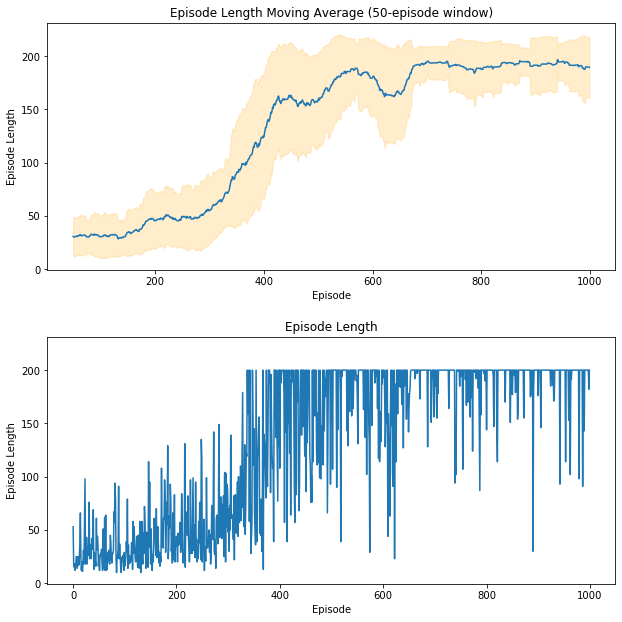

In [7]:
window = int(N_EPISODES/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9])
rolling_mean = pd.Series(reward_history).rolling(window).mean()
std = pd.Series(reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

ax2.plot(reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
fig.savefig('images/actor_critic.png')
plt.show()